In [239]:
#from scipy.ndimage.interpolation import rotate
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
import matplotlib
import open3d as o3d
import cl
import utils as ut
import numpy as np
from skimage.morphology import binary_dilation
import proc3d
import json
from PIL import Image, ImageOps
from utils import *
import glob
import os
%matplotlib widget
# %matplotlib inline

In [110]:
'''import open3d as o3d
import cl
import utils as ut
import numpy as np
from skimage.morphology import binary_dilation
import proc3d
import json
from PIL import Image
from utils import *
import glob
import os
import cv2
from scipy.ndimage.interpolation import rotate'''


class space_carving_2d():
    def __init__(self, model_path, gt_mode=False, theta_bias=0, total_theta_positions=180, cube_view='static')
        # if dynamic, perspective of the camera seeing the cube changes according to position
        # if static, perspective is always the same
        self.cube_view = cube_view
        
        # theta position bias for simulating rotation of position of the object
        self.theta_bias = theta_bias
        
        # number of posible positions around the circle
        self.total_theta_positions = total_theta_positions
        
        # get all .png file names from folder path
        self.masks_files = sorted(
            glob.glob(os.path.join(model_path, 'masks', '*.png')))
        
        self.extrinsics = self.load_extrinsics(
            os.path.join(model_path, 'extrinsics'))
        
        self.bbox = json.load(
            open(os.path.join(model_path, 'bbox_general.json')))
        #self.bbox = json.load(open(os.path.join(
        #    model_path, '/home/pico/uni/romi/scanner_cube/bbox_min_max.json')))
        
        self.camera_model = json.load(
            open(os.path.join(model_path, 'camera_model.json')))
        self.intrinsics = self.camera_model['params'][0:4]

        params = json.load(open(os.path.join(model_path, 'params.json')))
        self.n_dilation = params["sc"]["n_dilation"]
        self.voxel_size = params['sc']['voxel_size']

        self.gt_mode = gt_mode

        # uses ground truth model 
        if self.gt_mode is True:
            self.gt = np.load(os.path.join(
                model_path, 'volumes', 'vol_64x64x64.npy'))
            self.gt_solid_mask = np.where(self.gt == 1, True, False)
            self.gt_n_solid_voxels = np.count_nonzero(self.gt_solid_mask)

        self.set_sc(self.bbox)

    def reset(self):
        del(self.sc)
        self.set_sc(self.bbox)

    def load_extrinsics(self, path):
        ext = []
        ext_files = glob.glob(os.path.join(path, '*.json'))
        assert len(ext_files) != 0, "json list is empty."
        for i in sorted(ext_files):
            ext.append(json.load(open(i)))
        return ext

    def load_mask(self, idx):
        img = cv2.imread(self.masks_files[idx], cv2.IMREAD_GRAYSCALE)
        return img

    def set_sc(self, bbox):
        x_min, x_max = bbox['x']
        y_min, y_max = bbox['y']
        z_min, z_max = bbox['z']

        nx = int((x_max - x_min) / self.voxel_size) + 1
        ny = int((y_max - y_min) / self.voxel_size) + 1
        nz = int((z_max - z_min) / self.voxel_size) + 1

        self.origin = np.array([x_min, y_min, z_min])
        self.sc = cl.Backprojection(
            [nx, ny, nz], [x_min, y_min, z_min], self.voxel_size)
        self.volume = self.sc.values()

    def carve(self, theta, phi):
        '''space carve in position phi(rows),theta(cols)
        phi and theta are steps of the scanner, not angles'''
        # if using theta bias add it to get the real theta position
        if self.theta_bias != 0:
            theta = self.calculate_theta_position(theta, -self.theta_bias)

        idx = (self.total_theta_positions * phi) + theta

        im = self.load_mask(idx)
        self.space_carve(im, self.extrinsics[idx])

        if self.theta_bias == 0:
            self.volume = self.sc.values()
        else:
            # convert theta bias  to degrees and rotate volume to
            # biased position
            self.volume = rotate(self.sc.values(),
                angle=self.theta_bias*(360//self.total_theta_positions), reshape=False)
        
        
         # rotate cube according to current camera position
         #self.volume = rotate(self.volume,angle=-idx*(360//self.total_theta_positions),reshape=False)

    def space_carve(self, mask, rt):
        '''do space carving on mask with preset parameters'''
        # mask = im.copy() #get_mask(im)
        rot = sum(rt['R'], [])
        tvec = rt['T']
        if self.n_dilation:
            for k in range(self.n_dilation):
                mask = binary_dilation(mask)
        self.sc.process_view(self.intrinsics, rot, tvec, mask)

    def gt_compare(self):
        '''compares current volume with ground truth (voxelwise) and returns percentage'''
        if self.gt_mode is False:
            return 0
        comp = np.where(self.gt == self.sc.values(), True, False)
        eq_count = np.count_nonzero(comp)
        #perc_sim = (eq_count/np.prod(gt_vol.shape) )*100.
        # perc_sim = (eq_count/682176)*100. #682176number of voxels of the volumes used here
        perc_sim = eq_count * 0.00014658973637301812
        return perc_sim

    def gt_compare_solid(self):
        ''' returns intersection of solid voxels (with 1;s) between ground truth and test_vol.
        It is the ratio between the intersecting solid voxels of current volume and groundtruth, 
        and the total numer of solid voxels found in both volumes'''
        if self.gt_mode is False:
            return 0
        
        # gets solid voxels array in current volume
        vol_solid_mask = np.where(self.sc.values() == 1, True, False)
        
        #gets the total number of solid voxels in current volume
        vol_n_solid_voxels = np.count_nonzero(vol_solid_mask)
        
        #gets number of solid voxels that intersect current vol and GroundTruth
        intersection = self.gt_solid_mask & vol_solid_mask
        n_intersection = np.count_nonzero(intersection)
        
        ratio = n_intersection / \
            (self.gt_n_solid_voxels + vol_n_solid_voxels - n_intersection)
        return ratio

    def calculate_theta_position(self, init_state, steps):
        '''calculates theta position (in steps) from current theta plus n steps'''
        n_pos = init_state + steps
        if n_pos > (self.total_theta_positions-1):
            n_pos -= self.total_theta_positions
        elif n_pos < 0:
            n_pos += self.total_theta_positions
        return n_pos

In [276]:
class space_carving_rotation_2d():
    def __init__(self, model_path, gt_mode=False, theta_bias=0, total_theta_positions=180, cube_view='static'):
        # if dynamic, perspective of the camera seeing the cube changes according to position
        # if static, perspective is always the same
        self.cube_view = cube_view
        
        # theta position bias for simulating rotation of position of the object
        self.theta_bias = theta_bias
        
        # number of posible positions around the circle
        self.total_theta_positions = total_theta_positions
        
        # get all .png file names of images from folder path
        self.img_files = sorted (
            glob.glob(os.path.join(model_path, 'imgs', '*.png')) )
            
        # get all .png file names of image masks from folder path
        self.masks_files = sorted(
            glob.glob(os.path.join(model_path, 'masks', '*.png')))
        
        self.extrinsics = self.load_extrinsics(
            os.path.join(model_path, 'extrinsics'))
        
        self.bbox = json.load(
            open(os.path.join(model_path, 'bbox_general.json')))
        #self.bbox = json.load(open(os.path.join(
        #    model_path, '/home/pico/uni/romi/scanner_cube/bbox_min_max.json')))
        
        self.camera_model = json.load(
            open(os.path.join(model_path, 'camera_model.json')))
        self.intrinsics = self.camera_model['params'][0:4]

        params = json.load(open(os.path.join(model_path, 'params.json')))
        self.n_dilation = params["sc"]["n_dilation"]
        self.voxel_size = params['sc']['voxel_size']

        self.gt_mode = gt_mode

        # uses ground truth model 
        if self.gt_mode is True:
            self.gt = np.load(os.path.join(
                model_path, 'ground_truth_volumes', 'vol_64x64x64' + \
                '_rot_'+ str(self.theta_bias).zfill(3) +'.npy'))
            self.gt_solid_mask = np.where(self.gt == 1, True, False)
            self.gt_n_solid_voxels = np.count_nonzero(self.gt_solid_mask)

        self.set_sc(self.bbox)

    def reset(self):
        del(self.sc)
        self.set_sc(self.bbox)

    def load_extrinsics(self, path):
        ext = []
        ext_files = glob.glob(os.path.join(path, '*.json'))
        assert len(ext_files) != 0, "json list is empty."
        for i in sorted(ext_files):
            ext.append(json.load(open(i)))
        return ext

    def load_mask(self, idx):
        img = cv2.imread(self.masks_files[idx], cv2.IMREAD_GRAYSCALE)
        return img
    
    '''def load_image(self,idx):
        img = Image.open(self.img_files[idx])
        cp = img.copy()                                                                                                     img.close()                                                                                                         return cp'''
    
    def get_image(self, theta, phi):
        biased_theta = self.calculate_theta_position(theta, -self.theta_bias)
        image_idx = (self.total_theta_positions * phi) + biased_theta
        
        img = Image.open(self.img_files[image_idx])
        #cp = img.resize((84,84))
        cp = ImageOps.grayscale(img)  #(cp)
        #cp = img.copy()
        img.close()
        return cp

    
    def set_sc(self, bbox):
        x_min, x_max = bbox['x']
        y_min, y_max = bbox['y']
        z_min, z_max = bbox['z']

        nx = int((x_max - x_min) / self.voxel_size) + 1
        ny = int((y_max - y_min) / self.voxel_size) + 1
        nz = int((z_max - z_min) / self.voxel_size) + 1

        self.origin = np.array([x_min, y_min, z_min])
        self.sc = cl.Backprojection(
            [nx, ny, nz], [x_min, y_min, z_min], self.voxel_size)
        self.volume = self.sc.values()

    def carve(self, theta, phi):
        '''space carve in position phi(rows),theta(cols)
        phi and theta are steps of the scanner, not angles'''
        # if using theta bias, use image of biased (shifted)theta with extrinsics
        #of current position to create a rotate model
        biased_theta = self.calculate_theta_position(theta, -self.theta_bias)
        image_idx = (self.total_theta_positions * phi) + biased_theta
        
        extrinsics_idx = (self.total_theta_positions * phi) + theta
        
        im = self.load_mask(image_idx)
        self.space_carve(im, self.extrinsics[extrinsics_idx])

        self.volume = self.sc.values()
        
        if self.cube_view == 'dynamic':
            # rotate cube according to current camera position
            #moves current position's perspective to cube position 0 so position 0
            #in cube always shows current position's perspective
            self.volume = rotate(self.volume,
                            angle=-theta*(360//self.total_theta_positions),reshape=False)

    def space_carve(self, mask, rt):
        '''do space carving on mask with preset parameters'''
        # mask = im.copy() #get_mask(im)
        rot = sum(rt['R'], [])
        tvec = rt['T']
        if self.n_dilation:
            for k in range(self.n_dilation):
                mask = binary_dilation(mask)
        self.sc.process_view(self.intrinsics, rot, tvec, mask)

    def gt_compare(self):
        '''compares current volume with ground truth (voxelwise) and returns percentage'''
        if self.gt_mode is False:
            return 0
        comp = np.where(self.gt == self.sc.values(), True, False)
        eq_count = np.count_nonzero(comp)
        #perc_sim = (eq_count/np.prod(gt_vol.shape) )*100.
        # perc_sim = (eq_count/682176)*100. #682176number of voxels of the volumes used here
        perc_sim = eq_count * 0.00014658973637301812
        return perc_sim

    def gt_compare_solid(self):
        ''' returns intersection of solid voxels (with 1;s) between ground truth and test_vol.
        It is the ratio between the intersecting solid voxels of current volume and groundtruth, 
        and the total numer of solid voxels found in both volumes'''
        if self.gt_mode is False:
            return 0
        
        # gets solid voxels array in current volume
        vol_solid_mask = np.where(self.sc.values() == 1, True, False)
        
        #gets the total number of solid voxels in current volume
        vol_n_solid_voxels = np.count_nonzero(vol_solid_mask)
        
        #gets number of solid voxels that intersect current vol and GroundTruth
        intersection = self.gt_solid_mask & vol_solid_mask
        n_intersection = np.count_nonzero(intersection)
        
        ratio = n_intersection / \
            (self.gt_n_solid_voxels + vol_n_solid_voxels - n_intersection)
        return ratio

    def calculate_theta_position(self, init_state, steps):
        '''calculates theta position (in steps) from current theta plus n steps'''
        n_pos = init_state + steps
        if n_pos > (self.total_theta_positions-1):
            n_pos -= self.total_theta_positions
        elif n_pos < 0:
            n_pos += self.total_theta_positions
        return n_pos

In [241]:
def plot_vol(vol):
    # for creating a responsive plot
    %matplotlib widget

    # importing required libraries
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt

    #x,y,z = np.where(vol[:64,:64,:128]==1)
    
    x,y,z = np.where(vol==1)

    # creating figure
    fig = plt.figure()
    ax = Axes3D(fig)

    #ax.set_xlim3d(0, 10)
    #ax.set_ylim3d(0, 10)
    #ax.set_zlim3d(0, 10)

    #ax.set_xlim3d(0, 140)
    #ax.set_ylim3d(0, 140)
    #ax.set_zlim3d(0, 140)

    # creating the plot
    ax.scatter(x, y, z, color='green',s=1)

    #x,y,z = np.where(spc.sc.values()==0)
    #plot_geeks = ax.scatter(x, y, z, color='red',s=1)

    # setting title and labels
    ax.set_title("3D plot")
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')
    ax.grid()
    
    #make  0 origin coincide in all axis
    ax.xaxis._axinfo['juggled'] = (0,0,0)
    ax.yaxis._axinfo['juggled'] = (1,1,1)
    ax.zaxis._axinfo['juggled'] = (2,2,2)
    
    ax.view_init(90, 0)

    # displaying the plot
    plt.show()

In [277]:
data_path = '/home/pico/uni/romi/scanner-gym_models/211_2d'
spc = space_carving_rotation_2d(data_path, theta_bias=45 ,gt_mode=True, cube_view='dynamic')

In [297]:
spc.carve(22,0)

In [280]:
for i in range(180):
    spc.carve(i,0)

In [203]:
for j in range(4):
        for i in range(180):
            spc.carve(i,j)

In [298]:
plot_vol(spc.volume)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

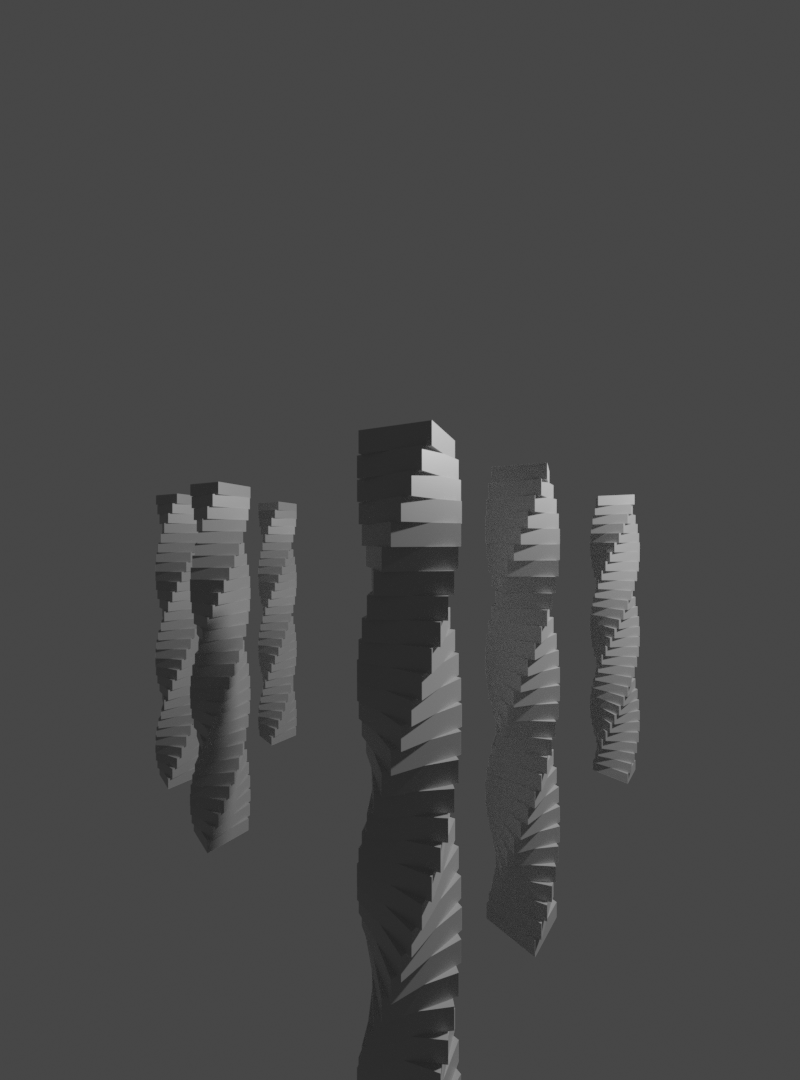

In [299]:
spc.get_image(22,0)

In [205]:
spc.volume.shape

(64, 64, 64)

In [206]:
spc.gt_compare_solid()

1.0